<a href="https://colab.research.google.com/github/inhyeoklee/DNA-LLM/blob/main/dna-lmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DEEP LEARNING IN GENOMICS SPRING 2025

### gLM TRAINING NOTEBOOK

**Authors**: Henry Raeder

**Acknowledgement**:



*   Andrej Karpathy (nanoGPT model framework)
*   Dalla-torre et. al. (Nucleotide Transformer workbook)



**Date**: 4/22/2025

## Introduction

In this notebook, we explore how one can pretrain and fine-tune a basic genomic language model (gLM). As the basis of our model, we use Andrej Karpathy's publicly-available [nanoGPT framework](https://github.com/karpathy/nanoGPT) (with some slight edits). This is a flexible implementation of a basic GPT model (based on GPT-2) that can take generic text as input. Here, we showcase how relatively sophisticated models can be trained efficiently, and how these can be fine-tuned to specific prediction tasks using datasets pulled from the [Nucleotide Transformer training notebook](https://github.com/huggingface/notebooks/blob/main/examples/nucleotide_transformer_dna_sequence_modelling.ipynb) (direct sources will be cited when datasets are introduced). Generally, the goal of this notebook is to provide hands-on experience in working with language models, and give insight into the fundamentals of attention-based deep learning.

## Steps

This notebook demonstrates how to:


*   Tokenize genomic data to be read by a language model
*   Train and sample from a generative language model
*   Fine-tune a model with additional training to perform specific tasks



## Setup

First, it is necessary to connect to the GPU. If you are working in Colab, this can be done in the upper right corner by selecting "T4 GPU" as your runtime option.

Next, we need to install a few things that help us build and run the model efficiently.



In [ ]:
%%capture
!pip install torch numpy transformers datasets tiktoken wandb tqdm biopython huggingface_hub accelerate
import os
import pickle
import requests
import numpy as np
import math
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import gc
import time
from contextlib import nullcontext
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader, TensorDataset
#from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Download and Read the Reference Genome

For our training, we will be using the GRCh38 human reference genome (credit to the Genome Reference Consortium: https://www.ncbi.nlm.nih.gov/grc). In the next block, we simply create a place to store our genome in the Colab filesystem and download the genome file remotely.

In [ ]:
!mkdir /root/data
fasta_file = '/root/data/genome.fa'
!wget -O - https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}

"""
Prepare the hg38 genomic dataset for character-level language modeling.
So instead of encoding with BPE tokens, we just map characters to ints.
Will save train.bin, val.bin containing the ids, and meta.pkl containing the
encoder and decoder and some other related info.
"""

# access the genome dataset
input_file_path = os.path.join('/root/data', 'genome.fa')


--2025-04-01 18:57:23--  https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  31.8MB/s    in 46s     

2025-04-01 18:58:10 (20.2 MB/s) - written to stdout [983659424/983659424]



Now that we have the genome file saved locally, we have to read it into our environment in order to make it usable. To do this, we just read in the entire file as one long string, which we can then subset and investigate as we wish. For example, we may want to know the total length of our dataset, and all of the unique characters we have:

In [ ]:
with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

length of dataset in characters: 3,273,481,150
all the unique characters: 
0123456789>ABCGHIJKLMNTUXY_acdghlmnortv
vocab size: 40


Great! The number of characters we have is approximately the same as the number of nucleotides in the human genome (about 3.2 billion), so it looks like our data imported correctly. However, you may notice that we have more characters than just "A", "T", "C", "G", and "N" as you may expect from genomic data. This is because our text file includes headers for each part of the genome assembly (i.e. chromosomes and fragments).

One nice thing about working with a language model is that we don't need to worry about this. Even if the input data is a bit messy, the model is essentially designed to predict the most likely characters based on a general input. Since the headers make up a tiny fraction of the total number of characters, our model will assign a very very low probability to each of the non-ATCGN characters, and they will not influence our outputs.

## Mapping Characters to Integers (i.e. Tokenization)

Now that we have our text, we need to put it into a format that is more easily readable for our model. Generally, this process is called Tokenization. There are many different methods for this, and each will impact the performance of the model differently (for example byte pair encoding or non-overlapping kmer tokenization used by other gLMs), but for the purpose of this notebook we will use a simple character-level tokenization. This means that we will simply assign a different integer to each unique character, and then transform our input into a long list of integers to be read by our model:

In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

In [ ]:
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

Now that we have our functions defined, it is time to actually do the tokenization. This will take a few minutes, so go ahead and run the block, and see the description of what it is doing below:

In [ ]:
# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

#save memory
del data

#helper function to store/append data to binary files and save RAM
def append_to_binary_file(filename, obj):
    with open(filename, 'ab') as file:  # Open in append-binary mode
        obj.tofile(file)

# encode both to integers
ntrain=len(train_data)
nval = len(val_data)
for i in np.arange(0,1,0.05):
  print(f"Tokenizing: {int(i*100):,}% complete")
  train_ids = encode(train_data[int(ntrain*i):int(ntrain*(i+0.05))])
  val_ids = encode(val_data[int(nval*i):int(nval*(i+0.05))])
  train_ids = np.array(train_ids, dtype=np.uint16)
  val_ids = np.array(val_ids, dtype=np.uint16)
  append_to_binary_file(os.path.join('/root/data', 'train.bin'), train_ids)
  append_to_binary_file(os.path.join('/root/data', 'val.bin'), val_ids)
print(f"train has {ntrain:,} tokens")
print(f"val has {nval:,} tokens")

Tokenizing: 0% complete
Tokenizing: 5% complete
Tokenizing: 10% complete
Tokenizing: 15% complete
Tokenizing: 20% complete
Tokenizing: 25% complete
Tokenizing: 30% complete
Tokenizing: 35% complete
Tokenizing: 40% complete
Tokenizing: 45% complete
Tokenizing: 50% complete
Tokenizing: 55% complete
Tokenizing: 60% complete
Tokenizing: 65% complete
Tokenizing: 70% complete
Tokenizing: 75% complete
Tokenizing: 80% complete
Tokenizing: 85% complete
Tokenizing: 90% complete
Tokenizing: 95% complete
train has 2,946,133,035 tokens
val has 327,348,115 tokens




1.   First, we are dividing the genome into a training and testing dataset using a simple 90/10 split.
2.   Next, we create a helper function that will help us save the integer lists locally. These end up taking up a lot of space in our Python environment, so it is better to save them to the disk and only access them when needed rather than having them sit and take up RAM.
3.   Finally, we actually go through and encode/tokenize our data. Since the dataset is so large, we don't have enough memory to do this all at once in Colab, so we encode our data in batches and then push each new batch to our locally-saved files.



We also want to save some of our metadata (i.e. vocabulary size, and our mappings from characters to integers and back) to pull back in later.

In [ ]:
# save the meta information as well, to help us encode/decode later
meta = {
    'vocab_size': vocab_size,
    'itos': itos,
    'stoi': stoi,
}
with open(os.path.join('/root/data', 'meta.pkl'), 'wb') as f:
    pickle.dump(meta, f)

In [ ]:
os.kill(os.getpid(), 9) #If running in a low-memory environment, this will clear our RAM. After this, go run the very first block again!

#### Questions:


1.   What does each "token" in our model represent? I.e. a single base, a stretch of a few bases, some functional region, etc.?
2.   What is the purpose of tokenization? Why is it necessary to train our model?



## Creating the Model

Now that we have our training data ready to go, it's time to actually create the gLM. First, we define the function we are going to use to do the heavy lifting in the attention layers. We will go into more detail on what we mean by attention during training, but if you are interested in what the implementation looks like, see the block below (and be sure to run it either way!)

In [ ]:
#Defining attention function (copied from Pytorch documentation, just need to save weights correctly)
def scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=0.0, is_causal=False, scale=None):
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
    attn_bias = torch.zeros(L, S, dtype=query.dtype, device=query.device)
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(L, S, dtype=torch.bool, device=query.device).tril(diagonal=0)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
        attn_bias.to(query.dtype)

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
        else:
            attn_bias += attn_mask
    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = torch.softmax(attn_weight, dim=-1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    return attn_weight, attn_weight @ value

Now that we have our attention function, it's time to define what our model will look like. This is a lot of code, so we will provide a short summary of what each layer is doing and the order in which they occur. If you are interested in the specifics, feel free to read through the code in detail.

The main model is created as a class simply called **GPT**. Within this model, we have a few different types of layers/elements:


*   **Embedding**: In our model, we project our relatively simple vocabulary (40 characters) into a higher-dimensional space in order to increase the model's capacity to understand more complex relationships between tokens. This is a bit difficult to visualize, but in essence Embedding layers just perform this projection and return the resulting dictionary to use later in our model. For language models, we usually embed both the tokens and the positions of the tokens, for reasons we will discuss later.
*   **LayerNorm**: As the name suggests, this layer simply applies normalization across the input features. This stabilizes the training, as it ensures each feature has a similar scale.
*   **Dropout**: Dropout layers randomly zero-out some of the elements in the input tensor. This serves as a form of regularization, and helps avoid overfitting our training data.
*   **Causal Self-Attention**: The mechanism of this layer will be described in further detail below, but this is the layer where our model learns the relationship between each of the tokens in the input, which is what gives it predictive power to generate what token will come next.
*   **MLP**: One can think of the MLP class as a mini neural network within our model. It is made up of a linear layer, a GELU activation layer, another linear layer, and finally a dropout layer. In short, the MLP element introduces non-linearity into our model, and helps us transform the output of our attention layer back into something we can pass through attention again, and decode into DNA sequence.
*   **Block**: This is not really a layer, it is more a sequence of layers. Specifically, we define a block as LayerNorm → Causal Self-Attention → LayerNorm → MLP

Now that we have these modules defined, the general outline of our GPT model is as below (assume the outputs of each step are passed to the next):


1.   Token and Position Embedding Layers
2.   Dropout layer
3.   Blocks (repeated $n$ times, i.e. if we want 6 attention layers we will have 6 Blocks)
4.   LayerNorm
5.   Linear layer to transform embedded outputs back into our vocab size
6.   Loss calculation (if training)



In [ ]:
"""
Full definition of a GPT Language Model, all of it in this single file.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""
gc.collect()

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            attn_weight, y = scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y, torch.mean(attn_weight, dim=0)

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        val, attn_weight = self.attn(self.ln_1(x))
        x = x + val
        x = x + self.mlp(self.ln_2(x))
        return x, attn_weight

@dataclass
class GPTConfig: #Default values for configuration, originally designed to match GPT-2, will override for training
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        #device = idx.device
        b, t = idx.size()
        weight_lst = []
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x, attn_weight = block(x)
            weight_lst.append(attn_weight)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss, weight_lst

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)[:2]
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

## Training

Now that our model constructors are ready, it's time to start training! First, see below for the configuration settings we are using for the model. Most of these are not important for the purposes of this notebook, but just note that we are creating a model with 4 attention layers with 4 heads each (more on that below), our embedding size is 384 (so our vocabulary gets projected into 384-dimensional space), and our block size/context size is 300, so our model will look at 300 bp of sequence as each input. Training will take a while (about 5-10 minutes), so run the code block below and go to the end for a description of the Attention mechanism and a rundown of what our training loop does.

In [ ]:
#@title Training Time!

gc.collect()
# -----------------------------------------------------------------------------
# default config values designed to train a gpt on hg38 reference genome
# I/O
out_dir = '/root/data/out'
eval_interval = 1000
log_interval = 100
eval_iters = 100
eval_only = False # if True, script exits right after the first eval
always_save_checkpoint = False # if True, always save a checkpoint after each eval
init_from = 'scratch' # 'scratch' or 'resume' or 'gpt2*'
# wandb logging
wandb_log = False # disabled by default
wandb_project = 'genome_char'
wandb_run_name = 'mini-gpt' # 'run' + str(time.time())
# data
dataset = 'genome_char'
gradient_accumulation_steps = 1 # used to simulate larger batch sizes
batch_size = 64 # if gradient_accumulation_steps > 1, this is the micro-batch size
block_size = 300
# model
n_layer = 4
n_head = 4
n_embd = 384
dropout = 0.2 # for pretraining 0 is good, for finetuning try 0.1+
bias = False # do we use bias inside LayerNorm and Linear layers?
# adamw optimizer
learning_rate = 1e-3 # max learning rate
max_iters = 4000 # total number of training iterations
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.99
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
decay_lr = True # whether to decay the learning rate
warmup_iters = 100 # how many steps to warm up for
lr_decay_iters = 4000 # should be ~= max_iters per Chinchilla
min_lr = 1e-4 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
# DDP settings
#backend = 'nccl' # 'nccl', 'gloo', etc.
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'float16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
if torch.cuda.is_available() and device == 'cuda':
    print('cuda')
else:
    print('CPU')
compile = True # use PyTorch 2.0 to compile the model to be faster
# -----------------------------------------------------------------------------
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
#exec(open('configurator.py').read()) # overrides from command line or config file
config = {k: globals()[k] for k in config_keys} # will be useful for logging
# -----------------------------------------------------------------------------

# various inits, derived attributes, I/O setup
master_process = True
seed_offset = 0
ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * batch_size * block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# poor man's data loader
data_dir = '/root/data'
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

# init these up here, can override if init_from='resume' (i.e. from a checkpoint)
iter_num = 0
best_val_loss = 1e9

# attempt to derive vocab_size from the dataset
meta_path = os.path.join(data_dir, 'meta.pkl')
meta_vocab_size = None
if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    meta_vocab_size = meta['vocab_size']
    print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")

# model init
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout) # start with model_args from command line
if init_from == 'scratch':
    # init a new model from scratch
    print("Initializing a new model from scratch")
    # determine the vocab size we'll use for from-scratch training
    if meta_vocab_size is None:
        print("defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)")
    model_args['vocab_size'] = meta_vocab_size if meta_vocab_size is not None else 50304
    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)
# crop down the model block size if desired, using model surgery
if block_size < model.config.block_size:
    model.crop_block_size(block_size)
    model_args['block_size'] = block_size # so that the checkpoint will have the right value
model.to(device)

# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# optimizer
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
#if init_from == 'resume':
#    optimizer.load_state_dict(checkpoint['optimizer'])
checkpoint = None # free up memory

# compile the model
if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model) # requires PyTorch 2.0

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)[:2]
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# logging
if wandb_log and master_process:
    import wandb
    wandb.init(project=wandb_project, name=wandb_run_name, config=config)

# training loop
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model
running_mfu = -1.0
while True:

    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        if wandb_log:
            wandb.log({
                "iter": iter_num,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": lr,
                "mfu": running_mfu*100, # convert to percentage
            })
        if losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'config': config,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        with ctx:
            logits, loss = model(X, Y)[:2]
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        # get loss as float. note: this is a CPU-GPU sync point
        # scale up to undo the division above, approximating the true total loss (exact would have been a sum)
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5: # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break

cuda
tokens per iteration will be: 19,200
found vocab_size = 40 (inside /root/data/meta.pkl)
Initializing a new model from scratch
number of parameters: 7.10M
num decayed parameter tensors: 18, with 7,208,448 parameters
num non-decayed parameter tensors: 9, with 3,456 parameters
using fused AdamW: True
compiling the model... (takes a ~minute)


<ipython-input-31-03a1a1042406>:125: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


step 0: train loss 3.5630, val loss 3.6028
iter 0: loss 3.5876, time 19931.60ms, mfu -100.00%
iter 100: loss 1.4037, time 85.69ms, mfu 3.46%
iter 200: loss 1.3751, time 99.46ms, mfu 3.41%
iter 300: loss 1.3111, time 92.69ms, mfu 3.39%
iter 400: loss 1.3133, time 92.03ms, mfu 3.37%
iter 500: loss 1.1890, time 91.24ms, mfu 3.36%
iter 600: loss 1.2906, time 90.32ms, mfu 3.35%
iter 700: loss 1.2479, time 89.76ms, mfu 3.34%
iter 800: loss 1.2905, time 90.72ms, mfu 3.34%
iter 900: loss 1.2095, time 88.86ms, mfu 3.34%
step 1000: train loss 1.2508, val loss 1.1614
saving checkpoint to /root/data/out
iter 1000: loss 1.2353, time 11279.57ms, mfu 3.00%
iter 1100: loss 1.2422, time 88.94ms, mfu 3.04%
iter 1200: loss 1.3067, time 91.19ms, mfu 3.06%
iter 1300: loss 1.2559, time 92.67ms, mfu 3.07%
iter 1400: loss 1.2399, time 90.56ms, mfu 3.09%
iter 1500: loss 1.2584, time 90.36ms, mfu 3.11%
iter 1600: loss 1.2565, time 90.68ms, mfu 3.13%
iter 1700: loss 1.1971, time 89.16ms, mfu 3.14%
iter 1800: los

Now that we've started training, let's talk about Attention. The first paper which outlines the Transformer neural network architecture (which relies heavily on the Attention mechanism and is the basis for most large language models today) is [Attention is All you Need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). This paper describes the application of Attention in a machine translation model, but the underlying ideas can be applied across any model that processes sequences of text.

At its core, the Attention mechanism allows us to analyze the pairwise relationship between every token in a given sequence. So, in a very simple example, if you're looking at the sentence "The cow jumped over the moon", and you are tokenizing by word, you may expect there to be a strong relationship between "jumped" and "over" (as one tends to jump over things), but not between the two iterations of "the". Below, I describe the actual mechanism behind this in plain language. It will be an oversimplification, but hopefully it can provide some context into what our model is doing.

The way we model this using Attention is via Query (Q), Key (K), and Value (V) matrices. In short, the input into the Attention layer goes through three separate matrix multiplication processes with different weights to create Q, K, and V. The idea behind these matrices is that Q represents each position/token in the sequence, and what information each of those positions is "looking for". K represents the information that each position contains, and therefore the actual Attention Score is obtained by doing matrix multiplication on Q and K. If two positions are a good match, they will have a higher attention score. The authors of the [Enformer](https://www.nature.com/articles/s41592-021-01252-x) paper provide a good, simplified visualization of this, where darker colors represent a stronger relationship in the Key vector to the given Q position:

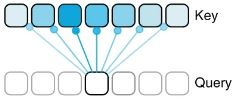

Once we have our Attention score matrix, we then multiply this by the V matrix, which represents the actual information of each token. This puts the Attention scores back into the context of the original token embeddings, which can then be passed to future layers.

One thing to note is that this calculation is often done in parallel, across multiple "heads" within a single layer. The idea behind this is that each head can learn different weights, and therefore multiple types of relationships between tokens can be represented within the same model. The [Attention is All you Need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) paper provides a good diagram of the Attention process, and what multi-head attention looks like (note that Scaled Dot-Produce Attention is essentially the process we just described):

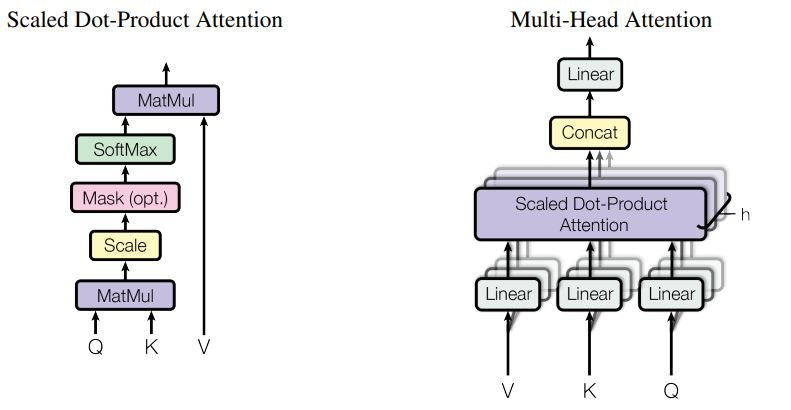

Now that we've defined the Attention mechanism, our training loop is actually pretty straightforward. See below for the steps:


1.   Generate a batch from our training data: This consists of sampling a 300 bp sequence out of the genome as our "data", then the same 300 bp but shifted over by 1 as our "labels". Our batch size is 64, so a single batch will be 64 of these pairs of sequences
2.   Plug the batch into our model to calculate loss. Our model is "causal", so it tries to predict the next token based on all previous tokens (i.e. data[0] is used to predict label[0], data[0:1] is used to predict label[1], data[0:2] is used to predict label[2], etc.)
3.   Once we have calculated the loss (using Cross Entropy Loss), we begin the backward pass and take a step based on the gradients of all of our parameters.
4.   Grab another batch and repeat
5.   Once we hit the evaluation interval (1000 batches), we pause our model training, and evaluate the average loss over 100 additional batches of the training and validation sets, to get a checkpoint of our model performance
6.   If the performance on the validation data is the best we've seen yet, we save this version of the model as a checkpoint to use later.

Obviously there is quite a bit more code than just these steps above, but this summary covers all of the functionally important parts. Much of the extra code above is related to making the model run efficiently, keeping track of how long it has been running, ensuring we are allocating GPU/CPU memory correctly, etc.





## Sampling from the model

Great! Now that we have a trained model, let's see what it can generate it. The code block below simply pulls out the highest-performing version of the model we just trained, and feeds it a newline character to see what it will generate:

Sampling from the model

In [ ]:
"""
Sample from a trained model
"""

# -----------------------------------------------------------------------------
init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = '/root/data/out' # ignored if init_from is not 'resume'
start = "\n" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 5 # number of samples to draw
max_new_tokens = 250 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True # use PyTorch 2.0 to compile the model to be faster
# -----------------------------------------------------------------------------

torch.cuda.init()
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}['float16']
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# model
if init_from == 'resume':
    # init from a model saved in a specific directory
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)

model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)

# look for the meta pickle in case it is available in the dataset folder
load_meta = False
if init_from == 'resume' and 'config' in checkpoint and 'dataset' in checkpoint['config']: # older checkpoints might not have these...
    meta_path = os.path.join('/root/data', 'meta.pkl')
    load_meta = os.path.exists(meta_path)
if load_meta:
    print(f"Loading meta from {meta_path}...")
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
    stoi, itos = meta['stoi'], meta['itos']
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])

# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

number of parameters: 7.10M
Loading meta from /root/data/meta.pkl...

ATGGACCCTGATCCCATTTCTCCTTTGGCTTTTTCAGCTCTGCAGCCTCT
CAGGAACAATCAGGAGAAAAGGTCAAAATCCATGTGAAGGGAAACAGACA
AGAATGTAACTGAAAAAATGTAATTCAGGCTCTGGGAAACCAGCAGAAGT
CTTCTTTTAGTTCTAACCTGTTTTCTCTGAAGATTTTTTTCATATATCCA
ATGCAAGCCAGGCTTAAAGTATAGAAACGCTCTGTTTCAGCTTCTT
---------------

ttctctttttctccaggttccagtttaggccttaaagtatatgaatcggg
tatttgctccattatagttacttgttacttttccaagtgacaggtatttg
tttagcactccctattacttgtggaaatcatccatttttccttgtttcta
tttttttttagacaaaagatgagttaagtctgtcaggctcaggctctgtt
gcactctgcactggcaactctcactgcacaagtgctctccctccag
---------------

AATTTTTACATATTCTTTGCTTTTTTTATCATTTCCTCCTTTTTCCAATT
TTTTTCTTTCACATTTAGCAATTTTCACCTAACATTATTTTTTAACTCTA
TTTAGGCAATTTAGGCAGAATTGTGAATTAATATGGTTCTTGCTGAAATC
ACTTAAAGTAATGAAGAATGGAGAATACAGAATGTAGAAAATATTCTTTT
ATTTTTATAGTTATTAGGTTTAATTGACTATTTTCAATATTCCTTA
---------------

cttctgattgtatctttaaattctttcaatgaaaattccaaaagtgctcc
cagtcctttgtgactagcccttctaaagcagtagctagattcaccatcct
gtggcacctctcactccctcttgc

And voila, it looks like our model is generating DNA sequence! But, that begs the question, how do we evaluate whether our model is actually performing well? With natural language, it's pretty easy to tell whether an output makes sense or not, but it is not so simple with DNA. Therefore, let's talk about the process of fine-tuning our model for more specific tasks.

**Note for those interested**: You may also notice some uppercase and lowercase sequences. This is expected, as in our original file any soft-masked bases (i.e. lower-confidence segments) are lowercase rather than uppercase. The fact that our model is not mixing lower and uppercase bases is a good sign, as these should not be mixed based on sequencing assembly techniques.

#### Questions


1.   As mentioned above, our model is using "causal" self-attention, meaning that it is only paying attention to the ~300 tokens/base pairs that come before the current one. Does this align with how DNA interacts in a biological sense? Why or why not?
2.   What effect do you think adding more attention layers/heads to our model would have? What about training for more epochs? Are there any downsides to expanding our model in this way?
3.   What is the difference between the Query, Key, and Value matrices?



## Fine-Tuning (Promoter Classification)

Now that we have our gLM up and running, let's try applying it to two different problems. First, let's look at a promoter classification problem pulled from the [Nucleotide Transformer training notebook](https://github.com/huggingface/notebooks/blob/main/examples/nucleotide_transformer_dna_sequence_modelling.ipynb). In short, this dataset is made up of 300 bp sequences, each labelled as 1 for promoter or 0 for non-promoter. Let's try to train our language model to separate these classes!

Note: This data was pulled from the [DeePromoter](https://www.frontiersin.org/journals/genetics/articles/10.3389/fgene.2019.00286/full) paper, as cited below:

Oubounyt, M., Louadi, Z., Tayara, H., & Chong, K. T. (2019). DeePromoter: Robust Promoter Predictor Using Deep Learning. Frontiers in Genetics, 10. https://doi.org/10.3389/fgene.2019.00286

First, let's actually load in the data:

In [ ]:
# Load the promoter dataset from the InstaDeep Hugging Face resources
dataset_name = "promoter_all"
train_dataset_promoter = load_dataset(
        "InstaDeepAI/nucleotide_transformer_downstream_tasks",
        dataset_name,
        split="train",
        streaming= False,
        trust_remote_code=True
    )
test_dataset_promoter = load_dataset(
        "InstaDeepAI/nucleotide_transformer_downstream_tasks",
        dataset_name,
        split="test",
        streaming= False,
        trust_remote_code=True
    )

num_labels_promoter = 2

Next, let's separate out the labels from the actual DNA sequences, and separate 5% of our training data to use as a validation set (the test set is already separated).

In [ ]:
# Get training data
train_sequences_promoter = train_dataset_promoter['sequence']
train_labels_promoter = train_dataset_promoter['label']

# Split the dataset into a training and a validation dataset
train_sequences_promoter, validation_sequences_promoter, train_labels_promoter, validation_labels_promoter = train_test_split(train_sequences_promoter,
                                                                              train_labels_promoter, test_size=0.05, random_state=42)

# Get test data
test_sequences_promoter = test_dataset_promoter['sequence']
test_labels_promoter = test_dataset_promoter['label']

Now, let's take a quick look at what one of these examples looks like:

In [ ]:
idx_sequence = -1
sequence, label = train_sequences_promoter[idx_sequence], train_labels_promoter[idx_sequence]
print(f"The DNA sequence is {sequence}.")
print(f"Its associated label is label {label}.")

idx_TATA = sequence.find("TATA")

print(f"This promoter is a TATA promoter, as the TATA motif is present at the {idx_TATA}st nucleotide.")

The DNA sequence is CACACCAGACAAAATTTGGTTAATTTGCGCCCAATATTCATTACTTTGACCTAACCTTTGTTCTGAAGGCCGTGTACAAGGACAAGGCCCTGAGATTATTGCAACAGTAACTTGAAAAACTTTCAGAAGTCTATTCTGTAGGATTAAAGGAATGCTGAGACTATTCAAGTTTGAAGTCCTGGGGGTGGGGAAAAATAAAAAACCTGTGCTAGAAAGCTTAGTATAGCATGTAACTTTAGAGTCCTGTGGAGTCCTGAGTCTCCCACAGACCAGAACAGTCATTTAAAAGTTTTCAGGAAA.
Its associated label is label 1.
This promoter is a TATA promoter, as the TATA motif is present at the 221st nucleotide.


Now that we have all of our datasets, it is time to tokenize them using the same mapping that we created for our language model. first, we load them into a Dataset object so we can work with them more easily:

In [ ]:
# Promoter dataset
ds_train_promoter = Dataset.from_dict({"data": train_sequences_promoter,'labels':train_labels_promoter})
ds_validation_promoter = Dataset.from_dict({"data": validation_sequences_promoter,'labels':validation_labels_promoter})
ds_test_promoter = Dataset.from_dict({"data": test_sequences_promoter,'labels':test_labels_promoter})

Next, we do the actual tokenization. However, remember that our previous encoding function could only handle a single example at a time (since our initial data file was one long string). We define a new tokenizing function below to use the same process, but apply it to multiple separate sequences:

In [ ]:
def tokenize_function(examples):
  outputs = np.empty((0, 300), dtype='int16')
  for example in examples["data"]:
    outputs = np.vstack([outputs, encode(example)])
  return {
      'input_ids': outputs,
      'attention_mask': [1] * len(outputs),
  }

tokenized_datasets_train_promoter = ds_train_promoter.map(
    tokenize_function,
    batched=True,
    remove_columns=['data'],
)
tokenized_datasets_validation_promoter = ds_validation_promoter.map(
    tokenize_function,
    batched=True,
    remove_columns=['data'],
)
tokenized_datasets_test_promoter = ds_test_promoter.map(
    tokenize_function,
    batched=True,
    remove_columns=['data'],
)

Map:   0%|          | 0/50612 [00:00<?, ? examples/s]

Map:   0%|          | 0/2664 [00:00<?, ? examples/s]

Map:   0%|          | 0/5920 [00:00<?, ? examples/s]

Now that we've tokenized the data, let's load it into Tensor format (which Pytorch uses in its models). Then, we can create a DataLoader, which will automatically create batches of our data and put them into a format which our model can read easily:

In [ ]:
train_dataset = TensorDataset(torch.tensor(tokenized_datasets_train_promoter['input_ids'], device=device),
                              torch.tensor(tokenized_datasets_train_promoter['labels'], device=device))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)

validation_dataset = TensorDataset(torch.tensor(tokenized_datasets_validation_promoter['input_ids'], device=device),
                              torch.tensor(tokenized_datasets_validation_promoter['labels'], device=device))

validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=64)

test_dataset = TensorDataset(torch.tensor(tokenized_datasets_test_promoter['input_ids'], device=device),
                              torch.tensor(tokenized_datasets_test_promoter['labels'], device=device))

test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

In the last step before training, we have to actually define a slightly new type of model. Essentially all we need to do here is add one more linear layer to our old model, which takes the original output and projects it into a two-dimensional output. This means that the "new" model will output the probability of the example belonging to each class. To do this, we just create a new model which pulls in our language model and adds the new layer on top:

In [ ]:
class ClassificationModel(nn.Module):
  def __init__(self, base_model, num_labels):
    super(ClassificationModel, self).__init__()
    self.orig_model = base_model
    self.classifier = nn.Linear(base_model.config.vocab_size, num_labels)
    self.num_labels = num_labels

  def forward(self, input_ids, labels=None):
    outputs = self.orig_model(input_ids)
    logits = self.classifier(outputs[0][:, 0, :])
    attn_weights = outputs[2]

    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    return (logits, loss, attn_weights) if loss is not None else (logits, attn_weights)

Now that we have our new model defined, let's pull in the model we trained previously, and use it to create this new 2-label classification model:

In [ ]:
# -----------------------------------------------------------------------------
init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = '/root/data/out' # ignored if init_from is not 'resume'
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True # use PyTorch 2.0 to compile the model to be faster
# -----------------------------------------------------------------------------

torch.cuda.init()
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}['float16']
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# model
if init_from == 'resume':
    # init from a model saved in a specific directory
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)

new_model = ClassificationModel(base_model=model, num_labels=2)
new_model.eval()
new_model.to(device)
if compile:
    new_model = torch.compile(new_model) # requires PyTorch 2.0 (optional)

number of parameters: 7.10M


Now, go ahead and run the next block of code to train our new model. Again, this will take about 10 minutes, so go to the next paragraph for a description of what our training is actually doing.

Epoch 0, Batch 99, Train Loss: 1.1063430405626393, Val Loss: 0.6231417059898376, Val F1: 0.6400310318076028
Epoch 0, Batch 199, Train Loss: 0.6487831079959869, Val Loss: 0.5760113000869751, Val F1: 0.6394148020654045
Epoch 0, Batch 299, Train Loss: 0.5738660246133804, Val Loss: 0.5623756718067896, Val F1: 0.580917237743806
Epoch 0, Batch 399, Train Loss: 0.48655192732810976, Val Loss: 0.5180567063036419, Val F1: 0.6560951437066403
Epoch 0, Batch 499, Train Loss: 0.43198314726352693, Val Loss: 0.6837071414504733, Val F1: 0.5966209081309398
Epoch 0, Batch 599, Train Loss: 0.3338544069230556, Val Loss: 0.6534176901692436, Val F1: 0.6913214990138067
Epoch 0, Batch 699, Train Loss: 0.28144210785627366, Val Loss: 0.7827847940581185, Val F1: 0.6696741854636592
Epoch 1, Batch 99, Train Loss: 0.2596805543097526, Val Loss: 0.6212598060568174, Val F1: 0.7100534239922293
Epoch 1, Batch 199, Train Loss: 0.23270934507250784, Val Loss: 0.45308178734211696, Val F1: 0.8003613369467029
Epoch 1, Batch 29

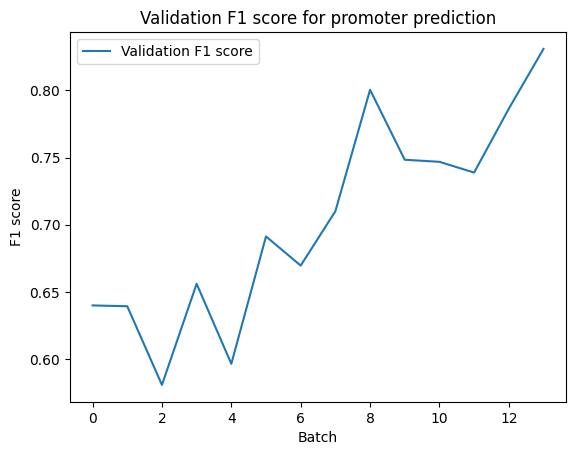

In [ ]:
optimizer = torch.optim.AdamW(new_model.parameters(), lr=2e-5)
num_epochs=2
total_steps = len(train_dataloader) * num_epochs

def calc_f1(predictions, true_labels):
    true_pos = 0
    false_pos = 0
    false_neg = 0
    true_neg = 0
    for i in np.arange(len(predictions)) :
        if predictions[i] == 0 and true_labels[i] == 0:
            true_neg += 1
        if predictions[i] == 1 and true_labels[i] == 0:
            false_pos += 1
        if predictions[i] == 0 and true_labels[i] == 1:
            false_neg += 1
        if predictions[i] == 1 and true_labels[i] == 1:
            true_pos += 1
    precision = true_pos / (true_pos + false_pos) if true_pos + false_pos > 0 else 0
    recall = true_pos / (true_pos + false_neg)
    F1 = (2*precision*recall / (precision + recall))
    return F1

val_predictions = []
val_true_labels = []

#Training Loop
loss_lst = []
val_loss_lst = []
f1_scores = []
new_model.train()
for epoch in range(num_epochs):
    i = 0
    for batch in train_dataloader:
        input_ids, labels = batch
        optimizer.zero_grad()

        # Forward pass
        outputs = new_model(input_ids, labels=labels)
        loss = outputs[1]
        loss_lst.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        i += 1
        if i % 100 == 99:
            new_model.eval()
            with torch.no_grad():
                for val_batch in validation_dataloader:
                    val_input_ids, val_labels = val_batch
                    optimizer.zero_grad()
                    val_outputs = new_model(val_input_ids, labels=val_labels)
                    val_loss = val_outputs[1]
                    val_loss_lst.append(val_loss.item())
                    val_logits = val_outputs[0]  # Get the logits
                    val_predictions.append(val_logits)
                    val_true_labels.append(val_labels)
                val_predictions = torch.cat(val_predictions, dim=0)
                val_true_labels = torch.cat(val_true_labels, dim=0)
                val_predictions = torch.argmax(val_predictions, dim=1).tolist()
                val_true_labels = val_true_labels.tolist()
                f1_scores.append(calc_f1(val_predictions, val_true_labels))
            print(f"Epoch {epoch}, Batch {i}, Train Loss: {np.mean(loss_lst)}, Val Loss: {np.mean(val_loss_lst)}, Val F1: {calc_f1(val_predictions, val_true_labels)}")
            loss_lst = []
            val_loss_lst = []
            new_model.train()
            val_predictions = []
            val_true_labels = []

plt.plot(f1_scores, label='Validation F1 score')
plt.title("Validation F1 score for promoter prediction")
plt.xlabel("Batch")
plt.ylabel("F1 score")
plt.legend()
plt.show()

With this new model, we want to be able to classify promoter sequences. But, how do we do this when our base model has already been trained on a different task? The answer lies in a process called **fine-tuning**. This is where you take a pre-trained model, and train it again to perform better on a specific task. In this case, we are relying on the fact that our model already understands the intrinsic relationships in genomic sequences well, and are just shifting its goal. Rather than predicting future genomic sequence, we want it to apply its "knowledge" of sequences to predict whether they are promoters or not.

For language models, oftentimes fine-tuning tasks are much simpler than the initial learning process (and we assume that the layers of our model other than the new classification layer are already trained), so we usually use a much smaller learning rate (in this case $2e^{-5}$ and fewer training iterations. This is not always true, but it is a good rule of thumb. There are many options you have to optimize fine-tuning, including freezing various layers so that their weights are not updated, using different learning rates for different layers, and much more. But, for the purposes of this notebook, we are simply going to fine-tune the entire model.

Our training loop is very similar here, but even simpler than our initial training:


1.   Take a batch from the training dataloader and pass it through the model to get loss
2.   Do the backward pass, and have our optimizer adjust weights according to each parameter's gradient and the learning rate
3.   Repeat for all batches
4.   Every 100 batches, run all validation samples through the model and calculate an average loss and F1 score (a metric for classification performance) for tracking purposes



Now that we've trained our model, let's run the test data through it and see how it performs. While we do so, let's also look at the attention weights for a specific test sample, and try to get some idea of what our model is doing:

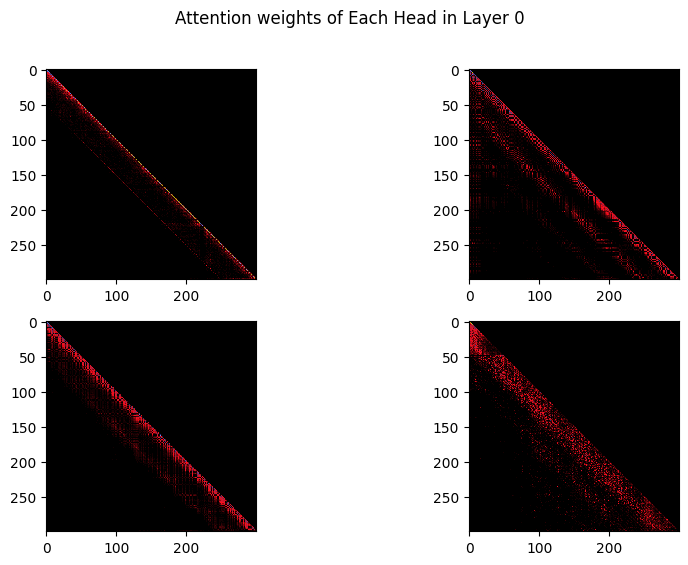

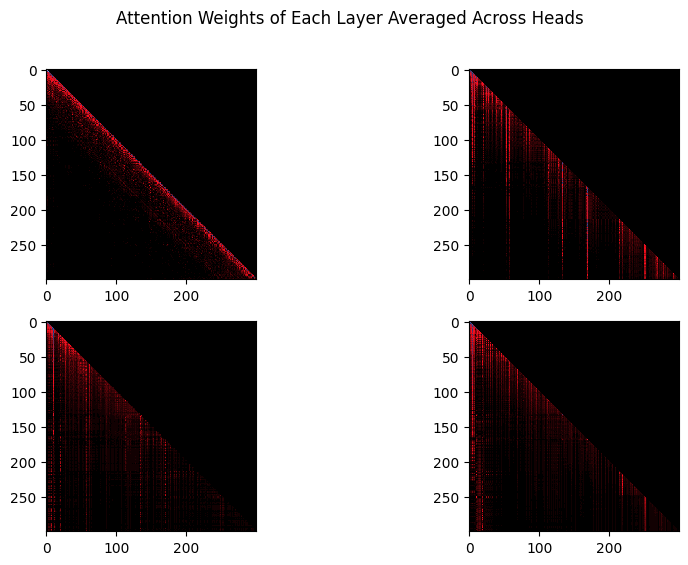

In [ ]:
new_model.eval()  # Set the model to evaluation mode

predictions = []
true_labels = []
i = 0

with torch.no_grad():  # Disable gradient calculation for inference
    for batch in test_dataloader:
        input_ids, labels = batch
        outputs = new_model(input_ids)
        logits = outputs[0]  # Get the logits
        predictions.append(torch.argmax(logits).item())
        true_labels.append(labels.item())
        if i == 3000:
            l = 0
            fig, axs = plt.subplots(2, 2)
            x = np.arange(2)
            y = np.arange(2)
            for j in x:
                for k in y:
                    axs[j,k].imshow(outputs[1][0][l].cpu().detach().numpy(), cmap='gist_stern', interpolation='nearest')
                    l += 1
            fig.set_figwidth(10)
            fig.set_figheight(6)
            fig.suptitle("Attention weights of Each Head in Layer 0")
            plt.show()
            l = 0
            fig, axs = plt.subplots(2, 2)
            x = np.arange(2)
            y = np.arange(2)
            for j in x:
                for k in y:
                    axs[j,k].imshow(torch.mean(outputs[1][l], dim=0).cpu().detach().numpy(), cmap='gist_stern', interpolation='nearest')
                    l += 1
            fig.set_figwidth(10)
            fig.set_figheight(6)
            fig.suptitle("Attention Weights of Each Layer Averaged Across Heads")
            plt.show()
        i += 1

In [ ]:
correct = 0
#print(len(predictions))
for i in np.arange(len(predictions)) :
    if predictions[i] == true_labels[i]:
        correct += 1
print(f"Accuracy:{int(correct / len(predictions) * 100):,}%")

true_pos = 0
false_pos = 0
false_neg = 0
true_neg = 0
for i in np.arange(len(predictions)) :
    if predictions[i] == 0 and true_labels[i] == 0:
        true_neg += 1
    if predictions[i] == 1 and true_labels[i] == 0:
        false_pos += 1
    if predictions[i] == 0 and true_labels[i] == 1:
        false_neg += 1
    if predictions[i] == 1 and true_labels[i] == 1:
        true_pos += 1
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)
print(f"Precision: {round(precision, 2):,}")
print(f"Recall: {round(recall, 2):,}")

F1 = calc_f1(predictions, true_labels)
print(f"F1 Score: {round(F1, 2):,}")

Accuracy:87%
Precision: 1.0
Recall: 0.75
F1 Score: 0.86


Wow, it looks like our model actually performs pretty well! Especially for a model that's gone through a total of 20 minutes of training on a single GPU. If we expanded our model or trained it over more data it would improve even further, but these are still good results.

Taking a look at the Attention graphs above, we can get some insight into what our model thinks is important for the given sample. The way to read these heatmaps is that the Queries are on the y-axis, and the Keys are on the x-axis. This is all mapped back to the original input, so we essentially have a set of base-by-base relationship heatmaps! For example, a vertical red line indicates that many Query positions saw that Key position as important in the classification task.

The first set is a breakdown of all of the heads of our first attention layer. As I mentioned above, we would expect each head to learn something slightly different about our input, and it appears that this is the case! For example, the second head was very focused on the relationships between the bases directly surrounding the query (which is why we have a bright diagonal line), while the 3rd and 4th heads had much more dispersed attention weights.

This pattern becomes even more apparent as we move to the second set of heatmaps, where we average the attention weights for all heads in each layer (to give an approximate idea of what each full layer learns about the input). At this level, we see some interesting patterns emerge. For example, multiple layers have strong attention weights at the position around 160-170 bp into the sequence, which means that it likely played an important role in deciding this sequence's classification. Each head and layer learned some unique things about the sequence, so take some time to try and understand what these heatmaps are showing!

#### Questions


1.   Promoters are known for having very characteristic structures of DNA sequence (i.e. TATA boxes as I mentioned above). How could this influence our classification accuracy (i.e. make the classification problem easier or harder)? Why?
2.   You can see that our validation F1 score metric does not uniformly increase across the training process. How can you explain this?
3.   Provide your interpretation of the graphs of the Attention weights above. Are there any locations in the input sequence that appear to be highly important (i.e. have a lot of "attention" on them)?



## Fine-Tuning (Enhancer Classification)

Now that we've introduced the idea of fine-tuning and have a simple example, let's move on to a more complicated task. We have another set of data from the [Nucleotide Transformer training notebook](https://github.com/huggingface/notebooks/blob/main/examples/nucleotide_transformer_dna_sequence_modelling.ipynb) which is made up of 200-bp sequences that are either labeled as strong enhancers, weak enhancers, or non-enhancers. This is a more complicated task not only because it is multi-class classification, enhancers also generally have less "characteristic" genomic structure compared to promoters. This means that (in theory) our model will have to understand more subtle relationships within each sequence to classify them correctly. This data comes from the below paper:

Geng, Q., Yang, R., & Zhang, L. (2022). A deep learning framework for enhancer prediction using word embedding and sequence generation. Biophysical Chemistry, 286, 106822. https://doi.org/10.1016/j.bpc.2022.106822

To start, we are going to load the data and tokenize it the exact same way we did previously:

In [ ]:
# Load the enhancer dataset from the InstaDeep Hugging Face ressources
dataset_name = "enhancers_types"
train_dataset_enhancers = load_dataset(
        "InstaDeepAI/nucleotide_transformer_downstream_tasks",
        dataset_name,
        split="train",
        streaming= False,
        trust_remote_code=True
    )
test_dataset_enhancers = load_dataset(
        "InstaDeepAI/nucleotide_transformer_downstream_tasks",
        dataset_name,
        split="test",
        streaming= False,
        trust_remote_code=True
    )

num_labels_enhancer = 3

In [ ]:
# Get training data
train_sequences_enhancers = train_dataset_enhancers['sequence']
train_labels_enhancers = train_dataset_enhancers['label']

# Split the dataset into a training and a validation dataset
train_sequences_enhancers, validation_sequences_enhancers, train_labels_enhancers, validation_labels_enhancers = train_test_split(train_sequences_enhancers,
                                                                              train_labels_enhancers, test_size=0.10, random_state=42)

# Get test data
test_sequences_enhancers = test_dataset_enhancers['sequence']
test_labels_enhancers = test_dataset_enhancers['label']

In [ ]:
ds_train_enhancers = Dataset.from_dict({"data": train_sequences_enhancers,'labels':train_labels_enhancers})
ds_validation_enhancers = Dataset.from_dict({"data": validation_sequences_enhancers,'labels':validation_labels_enhancers})
ds_test_enhancers = Dataset.from_dict({"data": test_sequences_enhancers,'labels':test_labels_enhancers})

In [ ]:
def tokenize_function(examples):
  min_length = min(len(i) for i in examples['data'])
  outputs = np.empty((0, min_length), dtype='int16')
  for example in examples["data"]:
    outputs = np.vstack([outputs, encode(example[:min_length])])
  return {
      'input_ids': outputs,
      'attention_mask': [1] * len(outputs),
  }

tokenized_datasets_train_enhancer = ds_train_enhancers.map(
    tokenize_function,
    batched=True,
    remove_columns=['data'],
)
tokenized_datasets_validation_enhancer = ds_validation_enhancers.map(
    tokenize_function,
    batched=True,
    remove_columns=['data'],
)
tokenized_datasets_test_enhancer = ds_test_enhancers.map(
    tokenize_function,
    batched=True,
    remove_columns=['data'],
)

train_dataset = TensorDataset(torch.tensor(tokenized_datasets_train_enhancer['input_ids'], device=device),
                              torch.tensor(tokenized_datasets_train_enhancer['labels'], device=device))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)

validation_dataset = TensorDataset(torch.tensor(tokenized_datasets_validation_enhancer['input_ids'], device=device),
                              torch.tensor(tokenized_datasets_validation_enhancer['labels'], device=device))

validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=1)

test_dataset = TensorDataset(torch.tensor(tokenized_datasets_test_enhancer['input_ids'], device=device),
                              torch.tensor(tokenized_datasets_test_enhancer['labels'], device=device))

test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=1)

Map:   0%|          | 0/13471 [00:00<?, ? examples/s]

Map:   0%|          | 0/1497 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Now, let's load back in our **original** gLM, i.e. not the one we fine-tuned to classify promoters. This time, we need it to classify on 3 labels rather than 2, so it is simpler to just recreate a new version and fine-tune it from scratch.

In [ ]:
# -----------------------------------------------------------------------------
init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = '/root/data/out' # ignored if init_from is not 'resume'
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = True # use PyTorch 2.0 to compile the model to be faster
# -----------------------------------------------------------------------------

torch.cuda.init()
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}['float16']
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# model
if init_from == 'resume':
    # init from a model saved in a specific directory
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)

new_model = ClassificationModel(base_model=model, num_labels=3)
new_model.eval()
new_model.to(device)
if compile:
    new_model = torch.compile(new_model) # requires PyTorch 2.0 (optional)

number of parameters: 7.10M


Now, let's run through the same training loop. You may notice that we have greatly increased the number of epochs we are training for. This is partially due to the fact that the enhancer dataset is much smaller than the promoter dataset (so we need more epochs to get the equivalent number of training batches), but the task is also more complex, so it benefits our model to have more training iterations in general.

In [ ]:
optimizer = torch.optim.AdamW(new_model.parameters(), lr=2e-5)
num_epochs=10
total_steps = len(train_dataloader) * num_epochs

val_predictions = []
val_true_labels = []

#Training Loop
loss_lst = []
val_loss_lst = []
mcc_scores = []
new_model.train()
for epoch in range(num_epochs):
    i = 0
    for batch in train_dataloader:
        input_ids, labels = batch
        optimizer.zero_grad()

        # Forward pass
        outputs = new_model(input_ids, labels=labels)
        loss = outputs[1]
        loss_lst.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        i += 1
        if i % 100 == 99:
            new_model.eval()
            with torch.no_grad():
                for val_batch in validation_dataloader:
                    val_input_ids, val_labels = val_batch
                    optimizer.zero_grad()
                    val_outputs = new_model(val_input_ids, labels=val_labels)
                    val_loss = val_outputs[1]
                    val_loss_lst.append(val_loss.item())
                    val_logits = val_outputs[0]  # Get the logits
                    val_predictions.append(torch.argmax(val_logits).item())
                    val_true_labels.append(val_labels.item())
            print(f"Epoch {epoch}, Batch {i}, Train Loss: {np.mean(loss_lst)}, Val Loss: {np.mean(val_loss_lst)}, Val MCC: {matthews_corrcoef(val_true_labels, val_predictions)}")
            mcc_scores.append(matthews_corrcoef(val_true_labels, val_predictions))
            loss_lst = []
            val_loss_lst = []
            new_model.train()
            val_predictions = []
            val_true_labels = []

Epoch 0, Batch 99, Train Loss: 1.6950590881434353, Val Loss: 1.0294456615715561, Val MCC: 0.02337836170240951
Epoch 0, Batch 199, Train Loss: 1.0240127527713776, Val Loss: 0.9334703189984671, Val MCC: 0.2029575954481794
Epoch 1, Batch 99, Train Loss: 0.9562811260824805, Val Loss: 0.8679180646722088, Val MCC: 0.2882548591515819
Epoch 1, Batch 199, Train Loss: 0.9066473466157913, Val Loss: 0.8179539945312516, Val MCC: 0.3447210289533454
Epoch 2, Batch 99, Train Loss: 0.8668737824972685, Val Loss: 0.7752895569148844, Val MCC: 0.38088925781892596
Epoch 2, Batch 199, Train Loss: 0.8445350229740143, Val Loss: 0.7523973750730674, Val MCC: 0.4857463009395969
Epoch 3, Batch 99, Train Loss: 0.8001560456043965, Val Loss: 0.7638596965543771, Val MCC: 0.4827095565854299
Epoch 3, Batch 199, Train Loss: 0.7579358673095703, Val Loss: 0.6510186637966392, Val MCC: 0.5660653939506216
Epoch 4, Batch 99, Train Loss: 0.7273919096401146, Val Loss: 0.6017526808513967, Val MCC: 0.612219373419949
Epoch 4, Batch

Now that we've finished training, we can see that our training loss remains significantly higher for this task than our promoter prediction task, as expected. Note that we use a slightly different performance metric here as well (MCC), which gives us a single scalar value for classification performance (whereas using F1 again would not be so simple). In any case, let's see how this model performs on the test data.

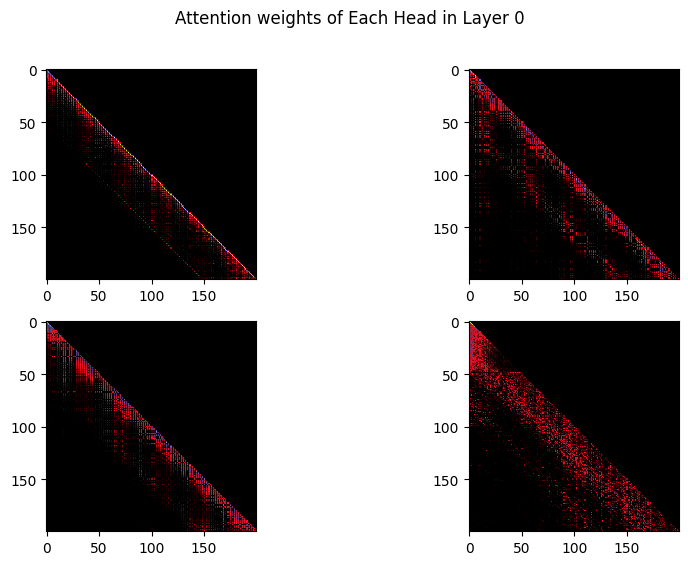

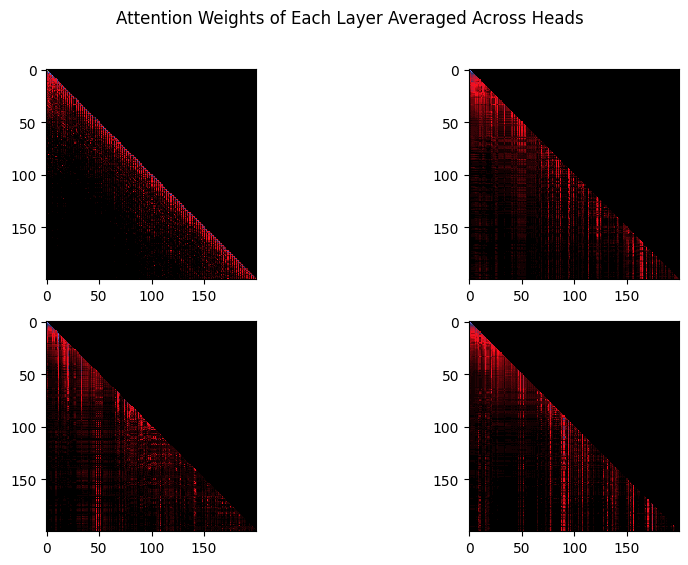

0


In [ ]:
new_model.eval()  # Set the model to evaluation mode

predictions = []
true_labels = []
i = 0

with torch.no_grad():  # Disable gradient calculation for inference
    for batch in test_dataloader:
        input_ids, labels = batch
        outputs = new_model(input_ids)
        logits = outputs[0]  # Get the logits
        predictions.append(torch.argmax(logits).item())
        true_labels.append(labels.item())
        if i == 200:
            l = 0
            fig, axs = plt.subplots(2, 2)
            x = np.arange(2)
            y = np.arange(2)
            for j in x:
                for k in y:
                    axs[j,k].imshow(outputs[1][0][l].cpu().detach().numpy(), cmap='gist_stern', interpolation='nearest')
                    l += 1
            fig.set_figwidth(10)
            fig.set_figheight(6)
            fig.suptitle("Attention weights of Each Head in Layer 0")
            plt.show()
            l = 0
            fig, axs = plt.subplots(2, 2)
            x = np.arange(2)
            y = np.arange(2)
            for j in x:
                for k in y:
                    axs[j,k].imshow(torch.mean(outputs[1][l], dim=0).cpu().detach().numpy(), cmap='gist_stern', interpolation='nearest')
                    l += 1
            fig.set_figwidth(10)
            fig.set_figheight(6)
            fig.suptitle("Attention Weights of Each Layer Averaged Across Heads")
            plt.show()
            print(labels.item())
        i += 1

In [ ]:
correct = 0
print(len(predictions))
for i in np.arange(len(predictions)) :
    if predictions[i] == true_labels[i]:
        correct += 1
print(f"Accuracy: {int(correct / len(predictions) * 100):,}%")

print(f"MCC: {round(matthews_corrcoef(true_labels, predictions), 2):,}")

400
Accuracy: 45%
MCC: 0.2


Oof, those numbers are a little rough, especially compared to our previous model's performance on promoter classification. If you look at the attention weight heatmaps, you can also see that the weights are significantly more spread out compared to the promoter model. This could mean many things, and it would take more digging to understand exactly what is happening, but one hypothesis is that our model couldn't quite understand what exactly to focus on for classification, so we get more "cloudy" attention signal.

In any case, this goes to show that sometimes there are limitations to the complexity that a single model can accurately represent. If we increased the size of our initial gLM and let it run for more training iterations, our performance on this task would likely improve dramatically. Unfortunately, we don't have the time or computing resources for that in this notebook, but I would encourage all of you to continue to investigate if you are interested!

#### Questions


1.   Why is this enhancer classification problem harder than the promoter classification problem we looked at previously?
2.   Similarly to the question above, provide your interpretation of the graphs of Attention weights.
3.   One characteristic of enhancers is that they tend to have some distance from the gene they influence (much greater than 300 bp). How could we potentially change our original gLM in order to potentially improve our performance in this problem?



## Conclusion

To sum up everything we have gone through in this notebook, here are a few major points:


1.   Large language models (LLMs) have become well-known for their popular use (i.e. ChatGPT), but they have strong potential for use as research tools in various fields as well.
2.   Genomic langauge models (gLMs) are a type of LLM that attempt to learn relationships between different of regions of DNA directly from DNA sequence.
3.   In general, gLMs can be created similarly to any other type of language model (usually using the Attention mechanism), however strategies for tokenization can differ due to the simplified vocabulary of DNA sequence.
4.   Once tokenization and embeddings are defined, a gLM can be trained just like any other language model.
5.   gLMs can be fine-tuned to perform specific tasks.

The applications of language modeling to functional genomic research is a very new field, and publications of high-performing models are just beginning to emerge. If you are interested in further investigation, we would highly recommend the [DNABERT-2](https://arxiv.org/abs/2306.15006) and [Nucleotide Transformer](https://www.biorxiv.org/content/10.1101/2023.01.11.523679v3.full) papers. These represent two distinctly different approaches to DNA language modeling, each with their own benefits and downsides.

